## Импорт библиотек и считывание файлов

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Импортируем все 3 необходимых файла для проекта и сразу приводим необходимые даннные к формату даты.

In [59]:
customers_ids_df = pd.read_csv('olist_customers_dataset.csv')

orders_df = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp',
                                                                 'order_approved_at',
                                                                 'order_delivered_carrier_date',
                                                                 'order_delivered_customer_date',
                                                                 'order_estimated_delivery_date'])

products_df = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

## Что мы считаем покупкой?

### Наши критерии покупки

Критерии покупки:

1) За единицу покупки берется заказ (1 заказ = 1 покупка);

2) Заказ должен быть завершен (мы рассматриваем только "delivered" в качестве завершенного статуса. в остальных случаях заказ могут отменить или заказ может быть недоступен для отправки - в таком случае мы обязаны будем вернуть деньги);

3) Заказ не должен закончиться возвратом денег (собственно во 2 пункте было описано, что статусы "canceled" и "unavailable" ненужно учитывать - они приводят к возврату денег);

4) Заказ должен быть оплачен (любая покупка сводится к получению денег. отслеживаем это по "order_approved_at". если заполнена дата - заказ оплачен, не заполнена дата - заказ не оплачен);

5) Заказ должен содержать товары, выбранные покупателем (если в таблице из "olist_order_items_dataset.csv" не окажется товарных позиций по заказу, то такие заказы нельзя считать покупкой. такие данные либо являются неполными либо некоторые заказы были тестовыми и т.д. при анализе данных есть риск неправильно их интерпретировать. также нет данных ценных данных о цене товара и сумме заказа.).

### Логическая последовательность статусов заказа

Логическая последовательность статусов заказа:

1) created ('создан') - незавершенный статус;

2) approved ('подтверждён') - незавершенный статус;

3) invoiced ('выставлен счёт') - незавершенный статус;

4) processing ('в процессе сборки заказа') - незавершенный статус;

5) shipped ('отгружен со склада') - незавершенный статус;

6) delivered ('доставлен пользователю') - завершенный статус.

Статусы без четкой последовательности:

1) unavailable ('недоступен') - завершенный статус (логически может появляться на разных этапах работы с заказом);

2) canceled ('отменён') - завершенный статус (может возникнуть на любом этапе работы с заказом).

### Особенности данных

Особенности:

1) У нас мало вводных о данных - что заставляет нас полагаться только на исследование данных и логику построения процееса обработки заказа;

2) Если сравнить order_approved_at ('время подтверждения оплаты заказа') с другими временными сериями то можно заметить, что оплата может возникнуть на самых разных этапах работы с заказом... (возможно присутствуют разные формы оплаты);

3) Не по всем заказам, указаны товары в 3 файле ('olist_order_items_dataset.csv')... (обычно такое встречается когда не все данные выгрузили либо часть данных утеряна вбазе данных);

4) Если сравнить серию "order_purchase_timestamp" с "order_delivered_customer_date", то можно узнать, что доставка закзов может происходить очень долго ( либо кто-то плохо сгенерировал данные:) ) - 200+ дней... поэтому висящие статусы "created', "approved", "invoiced", "processing", "shipped" - могут как отражать проблемы обработки заказа и доставки, так и не означать ничего (из-за огромных таймингов).

Ниже наглядно приведены показатели разницы между датами по 4 пункту.

In [60]:
# Разница между датой доставки пользователю и датой создания заказа.
total_number_days_df = pd.DataFrame()
total_number_days_df['days_to_delivery'] = (orders_df['order_delivered_customer_date'] - orders_df['order_purchase_timestamp']).dt.days
total_number_days_df = total_number_days_df.loc[~total_number_days_df['days_to_delivery'].isna()]
total_number_days_df.describe()

,days_to_delivery
count,96476.000000
mean,12.094086
std,9.551746
min,0.000000
25%,6.000000
50%,10.000000
75%,15.000000
max,209.000000


In [61]:
# Разница между датой доставки пользователю и датой доставки в кульерскую службу.
total_number_delivery_days_df = pd.DataFrame()
total_number_delivery_days_df['days_to_delivery'] = (orders_df['order_delivered_customer_date'] - orders_df['order_delivered_carrier_date']).dt.days
total_number_delivery_days_df = total_number_delivery_days_df.loc[~total_number_delivery_days_df['days_to_delivery'].isna()]
total_number_delivery_days_df.describe()

,days_to_delivery
count,96475.000000
mean,8.878310
std,8.746088
min,-17.000000
25%,4.000000
50%,7.000000
75%,12.000000
max,205.000000


## Задание №1

### Цель задания

Сколько у нас пользователей, которые совершили покупку только один раз?

### Решение

Исходя из наших критериев покупки приступим к выполнению задачи.

Первым делом нам необходимо отфильтровать датафрейм с заказами исходя из наших критериев покупки, после чего сохранить эти строки в новой переменной purchases_df ('покупки').

In [62]:
# Cоздаем список статусов, которые надо учитывать.
included_statuses = ['delivered']

# Оставляем все строки с удовлетворяющими нас статусами и непустыми значениями в 'order_approved_at'.
purchases_df = orders_df.loc[orders_df['order_status'].isin(included_statuses) & orders_df['order_approved_at'].notna()]

# Cоздаем серию номеров заказов из датафрейма с товарами и удаляем дубликаты.
orders_with_products_df = products_df[['order_id']].drop_duplicates()

# Оставляем только те заказы в датафрейме покупок, по которым есть информация о наличии товаров.
purchases_df = purchases_df.loc[purchases_df['order_id'].isin(orders_with_products_df['order_id'])]

# Убираем некоректные статусы 'delivered', у которых отсутствует дата доставки (эти заказы могут являться ошибкой в базе данных).
purchases_df = purchases_df.loc[purchases_df['order_delivered_customer_date'].notna()]

# Проверяем получившийся датафрейм покупок.
purchases_df[['order_status',
              'order_purchase_timestamp',
              'order_approved_at',
              'order_delivered_carrier_date',
              'order_delivered_customer_date']].groupby('order_status', as_index=False).count()

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,delivered,96456,96456,96455,96456


Теперь у нас есть необходимый датафрейм, который включает только покупки.

Следующим шагом нужно будет объединить данные о покупках с данными о пользователях (позволит нам понять сколько заказов будет приходится на уникального пользователя). После чего сразу рассчитаем сколько пользователей совершило ровно 1 покупку.

In [63]:
# Cоединяем датафрейм покупок (purchases_df) с датафреймом уникальных данных о покупателях (customers_ids_df).
customers_and_purchases_df = pd.merge(customers_ids_df, purchases_df, on=['customer_id'], how='inner')

# Подсчитываем количество покупок для каждого уникального покупателя.
customers_order_counts_df = customers_and_purchases_df[['customer_unique_id',
                                                        'order_id']].groupby('customer_unique_id', as_index=False) \
                                                                    .agg({'order_id': 'count'}) \
                                                                    .rename(columns={'order_id': 'purchases'}) \
                                                                    .sort_values(by='purchases', ascending=False)

# Оставляем только тех покупателей, у которых совершена ровно 1 покупка.
single_purchase_customers_df = customers_order_counts_df.loc[customers_order_counts_df['purchases'] == 1]

# Считаем общее коллчичество покупателей, у которых ровно 1 покупка
number_single_purchase_customers = single_purchase_customers_df['customer_unique_id'].count()

### Итог

In [64]:
print(f'Количество пользователей, которые совершили покупку только один раз: {number_single_purchase_customers}.')

Количество пользователей, которые совершили покупку только один раз: 90537.


## Задание №2

### Цель задания

Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

### Решение

Так как дата доставки может достигать 200+ дней и мы не можем точно предсказать для незавершенных статусов будут ли они доставлены наверняка, то в данной ситуации брать все статусы заказов мы не можем.

Поэтому логично рассмотреть только 3 завершающих статуса: 'canceled', 'unavailable', 'delivered'.

Для начала нам необходимо подготовить датафрейм с заказами, оставив в нем данные, где 'order_delivered_customer_date' - не заполнено. Такие заказы можно считать недоставленными. Также переименуем статусы в соответсвии с причинностью.

Проверять по оплате заказы не будем, так как не знаем есть ли у сервиса оплата после получения товара.

In [65]:
# Оставляем только те заказы, которые не имеют даты доставки. Такие заказы можно считать недоставленными.
undelivered_orders_df = orders_df.loc[~orders_df['order_delivered_customer_date'].notna()]

# Создаем список рассматриваемых статусов.
undelivered_statuses = ['canceled', 'unavailable', 'delivered']

# Оставляем только те заказы, где статус такой же как и в 'undelivered_statuses'.
undelivered_orders_df = undelivered_orders_df.loc[undelivered_orders_df['order_status'].isin(undelivered_statuses)]

# Переименовываем 'order_status' в 'reasons'.
undelivered_orders_df.rename(columns={'order_status': 'reasons'}, inplace=True)

# Переименовываем статусы заказов в соответсвии с тем, на ком лежит вина недоставленного заказа.
undelivered_orders_df['reasons'] = undelivered_orders_df['reasons'].replace({'delivered': 'сбой системы',
                                                                             'canceled': 'отмена заказа',
                                                                             'unavailable': 'товар отсутствует'})

In [66]:
# Проверяем получившийся датафрейм.
undelivered_orders_df[['reasons',
                       'order_purchase_timestamp',]].groupby('reasons', as_index=False) \
                                                    .count() \
                                                    .rename(columns={'order_purchase_timestamp': 'count'})

,reasons,count
0,отмена заказа,619
1,сбой системы,8
2,товар отсутствует,609


Дальше нам необходимо выделить из 'order_purchase_timestamp' период до месяца и посчитать сколько в среднем в месяц на каждую причину приходится недоставленных заказов.

In [67]:
# В подготовленном выше датафрейме из 'order_purchase_timestamp' выделяем период до месяца и записываем в новую серию.
undelivered_orders_df['year_month'] = undelivered_orders_df['order_purchase_timestamp'].dt.to_period('M')

# Рассчитываем в рамках периода количество недоставленных заказов по каждой причине.
monthly_undelivered_df = undelivered_orders_df[['year_month',
                                                'reasons',
                                                'order_id']].groupby(['year_month', 'reasons'], as_index=False) \
                                                            .count() \
                                                            .rename(columns={'order_id': 'quantity'}) \
                                                            .sort_values('year_month')

# Рассчитываем среднее значение недоставленных заказов в месяц (детализируем по причинам)
monthly_undelivered_df = monthly_undelivered_df[['reasons',
                                                 'year_month',
                                                 'quantity']].groupby('reasons') \
                                                             .agg({'quantity': 'mean'}) \
                                                             .round(2)

# Делаем для удобства сортировку и переименовываем серию.
monthly_undelivered_df = monthly_undelivered_df.sort_values(by='quantity', ascending=False) \
                                               .reset_index() \
                                               .rename(columns={'quantity': 'average_month'})

### Итог

Выводим среднее количество недоставленных заказов в месяц (детализация до причин).

In [68]:
monthly_undelivered_df['reasons'] = monthly_undelivered_df['reasons'].apply(lambda x: f"{x:<20}")
monthly_undelivered_df['average_month'] = monthly_undelivered_df['average_month'].apply(lambda x: f"{x:<5}")

print(f'Среднее количество недоставленных заказов в месяц.\nДетализация до причин.')
print(monthly_undelivered_df.to_string(index=False))

Среднее количество недоставленных заказов в месяц.
Детализация до причин.
              reasons average_month
 товар отсутствует            29.0 
 отмена заказа                25.79
 сбой системы                 2.0  


## Задание №3

### Цель задания

По каждому товару определить, в какой день недели товар чаще всего покупается.

### Решение

Для решения данной задачи нам необходимо в объединенном датафрейме (покупки + товары) получить имя дня недели из 'order_purchase_timestamp', а дальше просто правильно рассчитать количество покупок приходящихся на каждый товар в рамках каждого дня недели.

In [69]:
# Создаем датафрейм с данными о покупках и товарах.
purchases_and_products_df = pd.merge(purchases_df, products_df, on='order_id', how='inner')

# Сохраняем копию датафрейма в другую переменную.
most_popular_days_df = purchases_and_products_df.copy()

# Получаем название дня неделя из 'order_purchase_timestamp' и сохраняем в новую серию.
most_popular_days_df['day_of_week'] = most_popular_days_df['order_purchase_timestamp'].dt.day_name()

# Считаем сколько было куплено каждого товара в каждый день недели.
most_popular_days_df = most_popular_days_df[['product_id',
                                                       'day_of_week',
                                                       'customer_id']].groupby(['product_id',
                                                                                'day_of_week'], as_index=False) \
                                                                      .count() \
                                                                      .rename(columns={'customer_id': 'purchase_count'})

# Создаем серию, где по товару в каждой строке продублируем максимальное колличество покупок данного товара в неделю.
most_popular_days_df['max'] = most_popular_days_df[['product_id',
                                                    'purchase_count']].groupby('product_id', as_index=False) \
                                                                      .transform('max')

# Делаем фильтрацию для сохранения нескольких максимальных значений.
most_popular_days_df = most_popular_days_df.loc[most_popular_days_df['purchase_count'] == most_popular_days_df['max']]

# Удаляем технический столбец 'max'.
most_popular_days_df = most_popular_days_df.drop(columns='max')

# Сортируем данные по колличеству покупок и обнуляем индекс.
most_popular_days_df = most_popular_days_df.sort_values('purchase_count', ascending=False) \
                                           .reset_index(drop=True)

### Итог

In [70]:
print(f'Таблица товаров и день когда его чаще покупают.\nВыведены первые 10 строк.')
print(most_popular_days_df.head(10))

Таблица товаров и день когда его чаще покупают.
Выведены первые 10 строк.
                         product_id day_of_week  purchase_count
0  422879e10f46682990de24d770e7f83d   Wednesday              93
1  99a4788cb24856965c36a24e339b6058      Monday              91
2  aca2eb7d00ea1a7b8ebd4e68314663af    Thursday              89
3  53b36df67ebb7c41585e8d54d6772e08     Tuesday              76
4  389d119b48cf3043d311335e499d9c6b    Thursday              67
5  368c6c730842d78016ad823897a372db      Friday              67
6  53759a2ecddad2bb87a079a1f1519f73   Wednesday              66
7  d1c427060a0f73f6b889a5c7c61f2ac4      Monday              62
8  3dd2a17168ec895c781a9191c1e95ad7   Wednesday              53
9  a62e25e09e05e6faf31d90c6ec1aa3d1    Thursday              49


## Задание №4

### Цель задания

Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

### Решение

Для решения этой задачи необходимо сделать 2 вещи: 1) выделить период до месяца из 'order_purchase_timestamp', 2) расчитать для каждого месяца сколько в нем недель.

Также нужно не включать неполные месяцы.

Необходимый массив у нас был подготовлен заранее 'customers_and_purchases_df'.

In [71]:
# Находим неполные месяца.
print(customers_and_purchases_df.order_purchase_timestamp.min())
print(customers_and_purchases_df.order_purchase_timestamp.max())

2016-09-15 12:16:38
2018-08-29 15:00:37


In [72]:
# Делаем список неполных месяцев. В ходе задания будем исключать их.
excluted_dates = ['2016-09', '2018-09']

In [73]:
# Cохраняем датафрейм с данными о покупках и данными о пользователи в отдельную переменную.
average_weekly_purchases_df = customers_and_purchases_df.copy()

# Выделяем период до месяца из 'order_purchase_timestamp' и сохраняем в отдельную переменную.
average_weekly_purchases_df['year_month'] = average_weekly_purchases_df['order_purchase_timestamp'].dt.to_period('M')

# Рассчитываем сколько каждый пользователь совершил покупок в рамках каждог периода 'year_month'.
average_weekly_purchases_df = average_weekly_purchases_df[['customer_unique_id',
                                                           'year_month',
                                                           'order_id']].groupby(['customer_unique_id',
                                                                                 'year_month'], as_index=False) \
                                                                       .count() \
                                                                       .rename(columns={'order_id': 'purchase_count'})

# Создаем функцию, которая будет принимать период 'year_month', а возвращать количество дней в этом месяце.
# Не забывем, что к разнице между начальной датой и конечной датой нужно прибавлять 1.
def weeks_in_month(year_month):
    start = year_month.start_time
    end = year_month.end_time
    return round(((end - start).days + 1) / 7, 2)

# Применяем функцию 'weeks_in_month', к серии 'year_month' и получаем количество недель в каждом периоде 'year_month'.
average_weekly_purchases_df['weeks'] = average_weekly_purchases_df['year_month'].apply(weeks_in_month)

# Приводим 'year_month' к типу данных str. Иначе мы не сможем исключить неполные месяцы.
average_weekly_purchases_df['year_month'] = average_weekly_purchases_df['year_month'].astype(str)

# Исключаем строки с неполными месяцами.
average_weekly_purchases_df = average_weekly_purchases_df.loc[~average_weekly_purchases_df.year_month.isin(excluted_dates)]

# Теперь делем количество покупок в рамках периода 'year_month' на количество недель в этом периоде
# и получаем среднее значение по периоду'year_month' для каждого пользователя. Также округлим до 2 знаком после запятой.
average_weekly_purchases_df['avg_purchases_per_week'] = round(average_weekly_purchases_df['purchase_count']
                                                              / average_weekly_purchases_df['weeks'], 2)

# Оставляем только необходимые серии: id пользователя, период до месяца и среднее количество покупок.
average_weekly_purchases_df = average_weekly_purchases_df[['customer_unique_id',
                                                           'year_month',
                                                           'avg_purchases_per_week']]

### Итог

In [74]:
print(f'Среднее количество покупок пользователей в неделю (по месяцам).\nВыведены первые 10 строк.')
print(average_weekly_purchases_df.head(10))

Среднее количество покупок пользователей в неделю (по месяцам).
Выведены первые 10 строк.
                 customer_unique_id year_month  avg_purchases_per_week
0  0000366f3b9a7992bf8c76cfdf3221e2    2018-05                    0.23
1  0000b849f77a49e4a4ce2b2a4ca5be3f    2018-05                    0.23
2  0000f46a3911fa3c0805444483337064    2017-03                    0.23
3  0000f6ccb0745a6a4b88665a16c9f078    2017-10                    0.23
4  0004aac84e0df4da2b147fca70cf8255    2017-11                    0.23
5  0004bd2a26a76fe21f786e4fbd80607f    2018-04                    0.23
6  00050ab1314c0e55a6ca13cf7181fecf    2018-04                    0.23
7  00053a61a98854899e70ed204dd4bafe    2018-02                    0.25
8  0005e1862207bf6ccc02e4228effd9a0    2017-03                    0.23
9  0005ef4cd20d2893f0d9fbd94d3c0d97    2018-03                    0.23


## Задание №5

### Цель задания

Выполните когортный анализ пользователей.
В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.

### Решение

Для решения данной задачи нам необходимо понять какой период нужно брать для построения когортного анализа. Условия задачи говорят, что когорту с самым высоким retention найти в период с января по декабрь. Для этого нам нужно понять с какого момента начинается полный год.

Также нам нужно установить минимальную и максимальную дату для ограничения периода анализа.

In [75]:
# Смотрим первую и последнюю дату покупки.
print(f'Первая дата покупки: {orders_df.order_approved_at.min()}\n\
Последняя дата покупки: {orders_df.order_approved_at.max()}')

Первая дата покупки: 2016-09-15 12:16:38
Последняя дата покупки: 2018-09-03 17:40:06


Теперь нам стало понятно, что полноценно оценить мы можем 2017 год только - так как он является полным.

Таким образом, минимальной датой анализа будет '2017-01-01', а максимальной '2018-04-01' (чтобы оценить коготу '2017-12-31' до 3 месяца)

In [76]:
# Сохраняем в переменных обозначенные минимальную и максимальную даты анализа.
min_analysis_date = '2017-01-01'
max_analysis_date = '2018-04-01'

Теперь нужно подготовить все элементы для когортного анализа.

Признак формирования когорты — дата первой покупки;

Размер когорты — месяц;

Отчетный период — определены минимальной и максимальной датой анализа ('2017-01-01' по '2018-03-01');

Анализируемый ключевой показатель: Retention Rate.

In [77]:
# Сохраняем в новую переменную подготовленный датафрейм покупок и данными о пользователях.
cohort_analysis_df = customers_and_purchases_df.copy()

# Оставляем только те данные, где дата покупки больше либо равно минимальной дате анализа, но меньши либо равно максимальной дате анализа.
cohort_analysis_df = cohort_analysis_df.query('order_approved_at >= @min_analysis_date and order_approved_at <= @max_analysis_date')

# Извлекаем период до месяца из 'order_purchase_timestamp' и сохраняем в отдельную серию.
cohort_analysis_df['year_month'] = cohort_analysis_df['order_purchase_timestamp'].dt.to_period('M')

In [78]:
# Находим для каждого уникального покупателя дату первой покупки (год-месяц).
first_orders_df = cohort_analysis_df.groupby('customer_unique_id', as_index=False) \
                                    .agg({'year_month': 'min'}) \
                                    .sort_values('customer_unique_id') \
                                    .rename(columns={'year_month': 'first_order_year_month'})

In [79]:
# Теперь строим когорты.
# Создаем под это новый датафрейм. В нем будет обьединенные данные из 'cohort_analysis_df' c 'first_orders_df'.
cohorts_df = cohort_analysis_df[['customer_unique_id',
                                 'order_id',
                                 'year_month']].merge(first_orders_df, on='customer_unique_id')

# Для каждой когорты по месяцам считаем колличество пользователей.
cohorts_df = cohorts_df.groupby(['first_order_year_month',
                                 'year_month'], as_index=False) \
                       .agg({'customer_unique_id': 'nunique'}) \
                       .rename(columns={'customer_unique_id': 'user_count'})

# Проверяем, что получилось.    
cohorts_df.head()

,first_order_year_month,year_month,user_count
0,2017-01,2017-01,716
1,2017-01,2017-02,2
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3


In [80]:
# Создаем функцию, которая будет нумеровать месяцы по диапозону окна в когорте.
# Не дописываем в функцию +1 иначе нумерация будет с 1 и неправильно будут указаны месяцы для понимания анализа.
def cohort_period_number(df):
    df['cohort_period_number'] = np.arange(len(df))
    return df

# Применяем созданную функцию для нумерации месяца в 'first_order_year_month'.
cohorts_df = cohorts_df.groupby('first_order_year_month').apply(cohort_period_number)

# Сбрасываем индексы с удалением - иначе выдаст ошибки.
cohorts_df.reset_index(drop=True, inplace=True)

In [81]:
# Сохраняем отдельно размеры когорт. Они понадобятся для расчета retention.
cohort_sizes_df = cohorts_df[['user_count', 'first_order_year_month']].groupby('first_order_year_month') \
                                                                      .first() \
                                                                      .rename(columns={'user_count': 'cohort_size'})

# Проверяем, что получилось.
cohort_sizes_df.head()
     

,cohort_size
first_order_year_month,
2017-01,716
2017-02,1616
2017-03,2503
2017-04,2257
2017-05,3450


In [82]:
# Теперь расчитываем retention.
# Соединяем датафрейм 'cohorts_df' с 'cohort_sizes_df'.
retention_df = pd.merge(cohorts_df, cohort_sizes_df, on=['first_order_year_month'], how='left')

# В получившемся датафрейме расчитываем retention.
# Делим количество пользователей в рамках каждой когорты по месяцам на размер когорты
# (по сути это первоначальное количетсво пользователей в когорте).
retention_df['retention'] = retention_df['user_count'] / retention_df['cohort_size']

# Делаем таблицу.
retention_df = retention_df.pivot_table(columns='cohort_period_number',
                                        index ='first_order_year_month',
                                        values='retention')

# Смотрим, что получилось.
retention_df.head()

cohort_period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13
first_order_year_month,,,,,,,,,,,,,,
2017-01,1.0,0.002793,0.002793,0.001397,0.004190,0.001397,0.004190,0.001397,0.001397,0.004190,0.001397,0.006983,0.004190,0.001397
2017-02,1.0,0.001856,0.003094,0.001238,0.004332,0.001238,0.002475,0.001856,0.000619,0.001856,0.001238,0.003094,0.001238,0.001856
2017-03,1.0,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,0.003596,0.001199,0.001998,NaN
2017-04,1.0,0.006203,0.002215,0.001772,0.002658,0.002658,0.003545,0.003101,0.003101,0.001772,0.002658,0.000886,NaN,NaN
2017-05,1.0,0.004638,0.004638,0.002899,0.002899,0.003188,0.004058,0.001449,0.002609,0.002609,0.002609,NaN,NaN,NaN


### Итог

Визуализируем наш когортный анализ с помощью sns.heatmap.

Text(0.5, 48.0, 'Номер месяца')

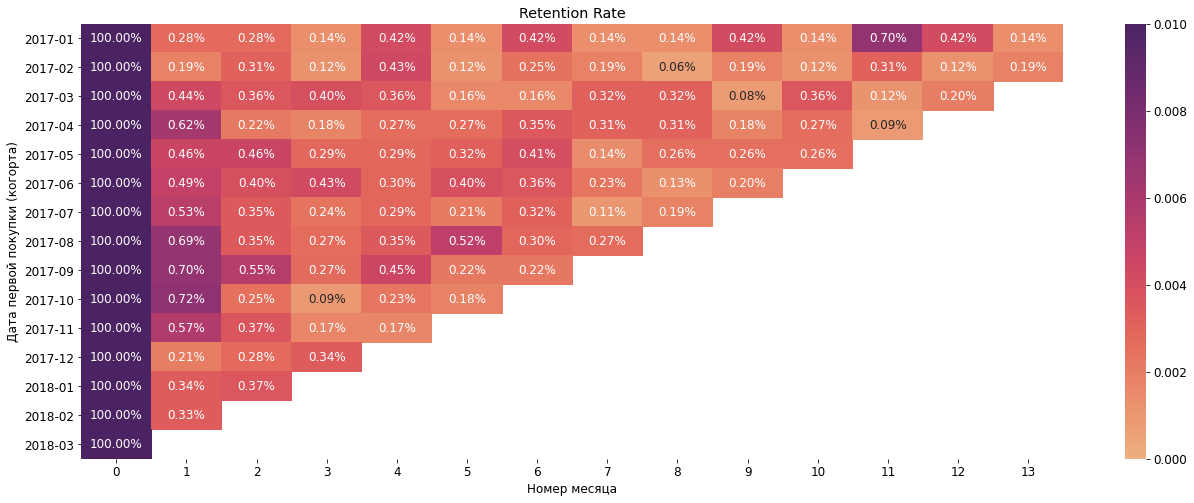

In [83]:
plt.rcParams['font.size'] = '12'
plt.figure(figsize=(22,8))
sns.heatmap(retention_df, mask=retention_df.isnull(), annot=True, fmt='.2%', vmin=0.0, vmax=0.01, cmap='flare')
plt.grid(False)
plt.title('Retention Rate')
plt.ylabel('Дата первой покупки (когорта)')
plt.xlabel('Номер месяца')

Смотрим 3 номер месяца, и определяем когорту с самым высоким retention.

In [84]:
print(f'Когорта с самым высоким retention на 3-й месяц с января по декабрь: 2017-06.')

Когорта с самым высоким retention на 3-й месяц с января по декабрь: 2017-06.


По когортному анализу наблюдаем, что удержание клиентов в целом слабая сторона исследуемого сервиса/компании. Однако полные выводы мы сделаем после RFM анализа

## Задание №6

### Цель задания

Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

### Решение

Для начала нам надо объединить датафрейм с покупками с данными пользователей и с данными о товарах.

In [85]:
# Объединяем готовый датафрейм покупок и данных о пользователях с данными о товарах.
rfm_df = pd.merge(customers_and_purchases_df, products_df, on=['order_id'], how='inner')

# Делаем проверку. 
print(purchases_df.shape)
print(products_df.shape)
print(purchases_df.shape[0] <= rfm_df.shape[0] <= products_df.shape[0])

(96456, 8)
(112650, 7)
True


Теперь нужно посчитать RFM сегменты:

R — время от последней покупки пользователя до текущей даты;

F — суммарное количество покупок у пользователя за всё время;

M — сумма покупок за всё время.

Оставим только необходимые данные из общего датафрейма.

In [86]:
# Нужно привести датафрейм в необходдимый вид.
rfm_df = rfm_df.groupby(['order_id',
                         'order_approved_at',
                         'customer_unique_id'], as_index=False) \
               .agg({'price': 'sum'}) \
               .sort_values('order_approved_at') \
               .rename(columns={'price': 'purchase_sum'}) \
               .reset_index(drop=True)

# Смотрим, что получилось     
rfm_df.head()

,order_id,order_approved_at,customer_unique_id,purchase_sum
0,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,134.97
1,1ff217aa612f6cd7c4255c9bfe931c8b,2016-10-04 09:43:32,14359ea0c7a105749c0a56478825b015,32.49
2,cd3b8574c82b42fc8129f6d502690c3e,2016-10-04 10:19:23,87776adb449c551e74c13fc34f036105,29.99
3,ed8c7b1b3eb256c70ce0c74231e1da88,2016-10-04 10:25:46,88bc832f104b6dd684a17dbb1b76e778,89.90
4,d207cc272675637bfed0062edffd0818,2016-10-04 10:28:07,8d3a54507421dbd2ce0a1d58046826e0,119.90


Данные старые. Нужно найти today_date.

In [87]:
# Находим и выводим последнюю дату оплаты покупки.
print(f'Последняя дата покупки:  {max(rfm_df.order_approved_at)}')

Последняя дата покупки:  2018-08-29 15:10:26


In [88]:
# Сохраняем получившуюся дату в переменную today_date.
today_date = '2018-08-29 15:10:26'

# Сразу приведем к типу даты.
today_date_datetime = datetime.strptime(today_date, '%Y-%m-%d %H:%M:%S')

Считаем показатели R, F и M.

In [89]:
# Считаем суммарное количество покупок у пользователей за все время и сумму покупок за все время.
rfm_df = rfm_df.groupby('customer_unique_id', as_index=False) \
               .agg({'order_approved_at': 'max',
                     'order_id': 'count',
                     'purchase_sum': 'sum'}) \
               .rename(columns={'order_id': 'frequency',
                                'purchase_sum': 'monetary'})

# Для удобства округлим 'monetary' до 2 знаков после запятой.
rfm_df['monetary'] = round(rfm_df['monetary'], 2)

# Считаем время от последней покупки пользователя до установленной текущей даты.
rfm_df['order_approved_at'] = today_date_datetime - rfm_df.order_approved_at

# Переименуем сразу 'order_approved_at' в 'recency'.
rfm_df = rfm_df.rename(columns={'order_approved_at': 'recency'})

# Смотрим, что получилось.
rfm_df.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,111 days 03:59:08,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113 days 20:44:42,1,18.90
2,0000f46a3911fa3c0805444483337064,536 days 18:05:23,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,320 days 18:21:09,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,287 days 19:03:34,1,180.00


Необходимо исследовать каждый показатель (recency, frequency, monetary), чтобы понять как распределить пользователей по кластерам.

In [90]:
# Для удобства ограничимся колличеством дней в 'recency'.

# Приводим 'recency' к типу str.
rfm_df['recency'] = rfm_df['recency'].astype(str)

# Через регулярную функцию и extract забираем только указанное колличесвто дней.
rfm_df['recency'] = rfm_df['recency'].str.extract(r'(\d+)\s+days')

# Приводим 'recency' к типу int.
rfm_df['recency'] = rfm_df['recency'].astype(int)

In [91]:
# Выведем статистическую информацию о показателях.
rfm_df.describe()

,recency,frequency,monetary
count,93337.000000,93337.000000,93337.000000
mean,236.487138,1.033417,141.622063
std,152.569502,0.209096,215.713022
min,0.000000,1.000000,0.850000
25%,113.000000,1.000000,47.650000
50%,218.000000,1.000000,89.700000
75%,345.000000,1.000000,154.700000
max,713.000000,15.000000,13440.000000


По frequency явно подавляющее большинство сделало только 1 покупку и распределение будет скошено. Его нужно будет детально посмотреть.

Сначала разделим на части recency. Данный показатель хорошо делится по квантилям. Но на вский случай проверим распределение. Если оно будет скученно в одном месте, то, как вариант, можно несколько раз по 75 перцентилю ограничивать ранги. Однако надо посмотреть распределение.

4 части для recency:

1) 4 ранг - чаще всего покупают;
2) 3 ранг - покупают чаще половины, но не дотягивают до самых частых;
3) 2 ранг - покупают реже половины, но не реже всего;
4) 1 ранг - покупают реже всего.

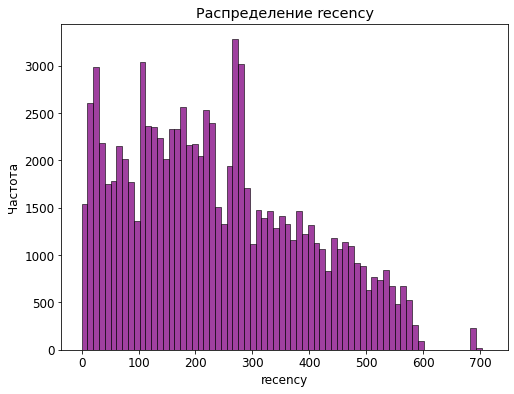

In [92]:
# Строим гистограмму, чтобы оценить распределение recency.
plt.figure(figsize=(8, 6))
sns.histplot(data=rfm_df, x='recency', color='purple')
plt.title('Распределение recency')
plt.xlabel('recency')
plt.ylabel('Частота')
plt.show()

На графике видно, что распределение примерно равномерное. Поэтому можно ограничивать ранги по 1, 2, 3 квантилям.

In [93]:
# Создаем переменные 1, 2, 3 квантиля.
recency_q25 = rfm_df.recency.quantile(0.25)
recency_q50 = rfm_df.recency.quantile(0.5)
recency_q75 = rfm_df.recency.quantile(0.75)

# Создаем функцию для присвоения рангов по показателю 'recency'. 4 - чаще всего покупают, 1 - реже всего покупают.
def recency_rank (column):
  if column < recency_q25:
    return 4
  elif column >= recency_q25 and column < recency_q50:
    return 3
  elif column >= recency_q50 and column < recency_q75:
    return 2
  elif column >= recency_q75:
    return 1

# Применяем нашу функцию для присвоения рангов.
rfm_df['r_rank'] = rfm_df.recency.apply(lambda x: recency_rank(x))

# Смотрим, что получилось.
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,r_rank
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,18.90,3
2,0000f46a3911fa3c0805444483337064,536,1,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,2
4,0004aac84e0df4da2b147fca70cf8255,287,1,180.00,2


Переходим к делению frequency. Тут нужно посмотреть распределение.

In [94]:
# Считаем значения по серии 'frequency'.
rfm_df.frequency.value_counts()

1     90537
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: frequency, dtype: int64

Даже без построения диаграммы нам наглядно видно, что есть скученность значений вокруг 1-2 покупок.

Исходя из увиденного стоит разделить на следующие 4 части:

1) 4 ранг - 4 и более покупок покупка;
2) 3 ранг - 3 покупки;
3) 2 ранг - 2 покупки;
4) 1 ранг - 1 покупка.

In [95]:
# Создаем функцию для присвоения рангов по показателю 'frequency'.
def frequency_rank(column):
  if column == 1:
    return 1
  elif column == 2:
    return 2
  elif column == 3:
    return 3
  elif column >= 4:
    return 4

# Применяем нашу функцию для присвоения рангов.
rfm_df['f_rank'] = rfm_df.frequency.apply(lambda x: frequency_rank(x))

# Смотрим, что получилось.
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,r_rank,f_rank
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,4,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,18.90,3,1
2,0000f46a3911fa3c0805444483337064,536,1,69.00,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,2,1
4,0004aac84e0df4da2b147fca70cf8255,287,1,180.00,2,1


Осталось сделать деление для  monetary.

Тут надо тоже глянуть распределение monetary.

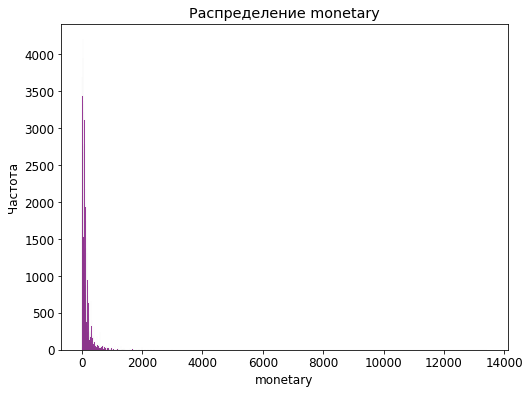

In [96]:
# Строим диаграмму для распределения monetary.
plt.figure(figsize=(8, 6))
sns.histplot(data=rfm_df, x='monetary', color='purple')
plt.title('Распределение monetary')
plt.xlabel('monetary')
plt.ylabel('Частота')
plt.show()

Тут мы видим неравномерное распределение. К тому же очень длинный правый хвост. Тут нельзя делить периоды аналогичным способом, как recency. Иначе ранги не будут отражать действительно значимые различия между собой.

Для этого можем необходимое колличество раз ограничить каждый оставшийся промежуток данных по 75 перцентилю.Тогда мы сможем сделать более значимые разлияи между рангами и в малой степени искажать картину.

In [97]:
# Находим 75 перцентиль - он будет ограничить первую и вторую группы.
monetary_q75_1 = rfm_df.monetary.quantile(0.75)
# Фильтруем значения monetary (оставляем все что больше 75 перцентиля)
# и находим на отфильтрованных данных новый 75 перцентиль - он будет ограничивать вторую и третью группы
monetary_q75_2 = rfm_df.loc[rfm_df.monetary > monetary_q75_1].monetary.quantile(0.75)
# Снова фильтруем значения monetary (оставляем все что больше второго 75 перцентиля)
# и снова находим на отфильтрованных данных новый 75 перцентиль - он будет ограничивать третью и четвертую группы
monetary_q75_3 = rfm_df.loc[rfm_df.monetary > monetary_q75_2].monetary.quantile(0.75)

# Создаем функцию для присвоения рангов по показателю 'monetary'.
def monetary_rank(column):
  if column < monetary_q75_1:
    return 1
  elif column >= monetary_q75_1 and column < monetary_q75_2:
    return 2
  elif column >= monetary_q75_2 and column < monetary_q75_3:
    return 3
  elif column >= monetary_q75_3:
    return 4

# Выведем границы monetary.
print(f'{monetary_q75_1}\n{monetary_q75_2}\n{monetary_q75_3}')

154.7
369.9
828.495


In [98]:
# Применяем нашу функцию для присвоения рангов.
rfm_df['m_rank'] = rfm_df.monetary.apply(lambda x: monetary_rank(x))

# Смотрим, что получилось и проверяем. 4 - лучшие ранги, 1 - худшие.
rfm_df.head(10)

,customer_unique_id,recency,frequency,monetary,r_rank,f_rank,m_rank
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,4,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,18.90,3,1,1
2,0000f46a3911fa3c0805444483337064,536,1,69.00,1,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,287,1,180.00,2,1,2
5,0004bd2a26a76fe21f786e4fbd80607f,145,1,154.00,3,1,1
6,00050ab1314c0e55a6ca13cf7181fecf,126,1,27.99,3,1,1
7,00053a61a98854899e70ed204dd4bafe,182,1,382.00,3,1,3
8,0005e1862207bf6ccc02e4228effd9a0,542,1,135.00,1,1,1
9,0005ef4cd20d2893f0d9fbd94d3c0d97,169,1,104.90,3,1,1


In [99]:
# Создадим серию 'rfm_score' и отобразим все 3 показателя.
rfm_df['rfm_score'] = rfm_df['r_rank'].astype(str) + rfm_df['f_rank'].astype(str) + rfm_df['m_rank'].astype(str)

# Смотрим, что получилось.
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,r_rank,f_rank,m_rank,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,4,1,1,411
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,536,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,287,1,180.00,2,1,2,212


Построение анализа готово. Осталось перейти к рассмотрению сегментов и выводам.

### Итог

Зафиксируем

444 - лучшие клиенты (покупали недавно, 4 и более покупок, суммы покупок от 828.5)

111 - потерянные клиенты (покупали очень давно, 1 покупка, сумма покупок до 154,7)

Остальные сегменты пока не будем расписывать, так как сначала нужно посмотреть какие из сегментов преобладают.

Соберем последнюю таблицу, в которой будет номер сегмента, количество пользователей в сегменте и доля сегмента.

In [100]:
# Собираем итоговый датафрейм rfm анализа.
rfm_itog_df = rfm_df[['rfm_score',
                      'customer_unique_id']].groupby('rfm_score', as_index=False) \
                                            .count() \
                                            .rename(columns={'customer_unique_id': 'segment_count'}) \
                                            .sort_values('segment_count', ascending=False)

# Делаем округление для колличества пользователей в сегменте до 2 знаков после запятой. 
rfm_itog_df['segment_percent'] = round((rfm_itog_df['segment_count'] * 100) / rfm_itog_df['segment_count'].sum(), 3)

# Обнуляем индекс.
rfm_itog_df.reset_index(drop=True, inplace=True)

# Выводим итоговую таблицу. Специально отсекаем  все показатели меньше 1 %.
print(f'Колличество пользователей в сегментах и доля сегмента')                                       
print(rfm_itog_df.head(12).to_string(index=False))

Колличество пользователей в сегментах и доля сегмента
rfm_score  segment_count  segment_percent
      311          17312           18.548
      211          17251           18.482
      111          17246           18.477
      411          17071           18.290
      112           4125            4.419
      212           4111            4.404
      312           4070            4.361
      412           3980            4.264
      113           1014            1.086
      213           1009            1.081
      313           1007            1.079
      413            985            1.055


Для удобства делаем круговую диаграмму.

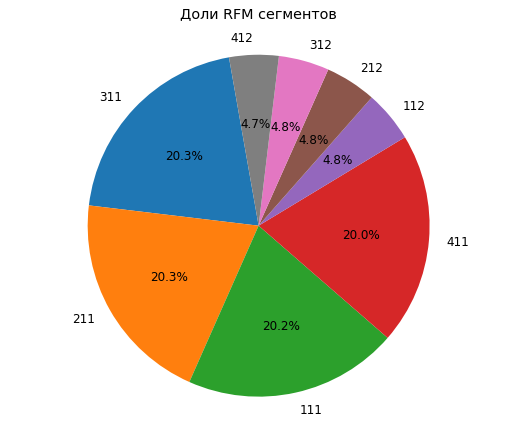

In [101]:
# Оставляем толко сегменты больше 4 % (остальные как мы заметили по таблице 1% или меньше)
rfm_pie_df = rfm_itog_df.loc[rfm_itog_df['segment_percent'] > 4]

# Создаем круговую диаграмму. (Увы по цветам будет выбиваться...зато наглядно)
plt.figure(figsize=(9, 7))
plt.pie(rfm_pie_df['segment_percent'],
        labels=rfm_pie_df['rfm_score'],
        autopct='%1.1f%%',
        startangle=100,
        textprops={'fontsize': 12})
plt.title('Доли RFM сегментов', pad=20)
plt.axis('equal')
plt.show()

У нас сложилась интересная ситуация. На основе итоговой таблицы и диаграммы - мы замечаем интересные тенденции.

У нас выделяются 2 группы сегментов:

1) Топ 4: 411, 311, 211, 111 - составляют 80,8% (сразу подмечу, что меняется только r - показатель, в остальном сегменты однородны);

2) Топ 5-8: 412, 312, 212, 112 - составляют 19,1% (сразу подмечу, что меняется только r - показатель, в остальном сегменты однородны).

В 99% попали сегменты только с 1 покупкой и относительно небольшими суммами покупок. Различие сегментов только в том, как давно пользователи что либо заказывали. Отсюда напрашивается следующие выводы: услуги нашей компании/сервиса использую в основном для разовых покупок и на относительно небольшие суммы. Наша основная аудитория - новоприбывшие пользователи, которые не удерживаются надолго и сменяются новыми пользователями (это видно по изменению только r показателя).

Однако, мы рассмотрели только количественный показатель сегментов. Надо посмотреть на топ доходных сегментов.


In [102]:
# Строем еще одну таблицу, которая будет отражать доходность сегментов и долю сегментов по доходности.
rfm_monetary_sum_df = rfm_df.groupby('rfm_score', as_index=False) \
                           .agg({'monetary': 'sum'}) \
                           .sort_values('monetary', ascending=False)

# Округляем показатель доли до 2 знаков после запятой.
rfm_monetary_sum_df['monetary_percent'] = round((rfm_monetary_sum_df['monetary'] * 100) / rfm_monetary_sum_df['monetary'].sum(), 2)

# Обнуляем индексы.
rfm_monetary_sum_df.reset_index(drop=True, inplace=True)

# Выводим таблицу, где показатели доли у сегментов больше 1 %.
print(f'Доходность от сегментов и процентное соотношение')    
print(rfm_monetary_sum_df.head(16).to_string(index=False))

Доходность от сегментов и процентное соотношение
rfm_score    monetary  monetary_percent
      311  1235727.82              9.35
      211  1218815.60              9.22
      411  1209972.13              9.15
      111  1179450.92              8.92
      112   930866.70              7.04
      212   925845.53              7.00
      312   916802.20              6.94
      412   889708.96              6.73
      213   537328.70              4.06
      113   536011.16              4.05
      313   524898.00              3.97
      413   524854.87              3.97
      114   521690.59              3.95
      414   514258.88              3.89
      314   420325.59              3.18
      214   403884.80              3.06


Построим диаграмму о доходности сегментов.

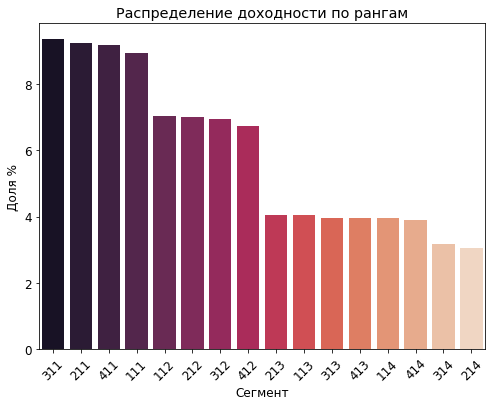

In [103]:
# Оставляем толко сегменты больше 4 % (остальные как мы заметили по таблице 1% или меньше)
rfm_monetary_barplot_df = rfm_monetary_sum_df.loc[rfm_monetary_sum_df['monetary_percent'] > 3]

plt.figure(figsize=(8, 6))
sns.barplot(data=rfm_monetary_barplot_df, x='rfm_score', y='monetary_percent', palette='rocket')
plt.xticks(rotation=45)
plt.title('Распределение доходности по рангам')
plt.xlabel('Сегмент')
plt.ylabel('Доля %')
plt.show()

И снова видим интересные наблюдения. Топ 8 по доходности сегментов совпадает с топ 8 сегментов по колличеству пользователей. Их суммарный процент 64,35 %. То есть наша компания/сервис зарабатывает на потоке новых клиентов, которые достаточно быстро перестают в принципе быть нашими клиентами.

Но нужно еще построить один график, но уже только по распределению рангов в monetary. По нему мы в принципе поймем не делаем ли мы ложных выводов. Напомню, что 1 - это покупки с самыми низкими суммами, 2-3 - середениа, 4 - это покупки с самими большими суммами.

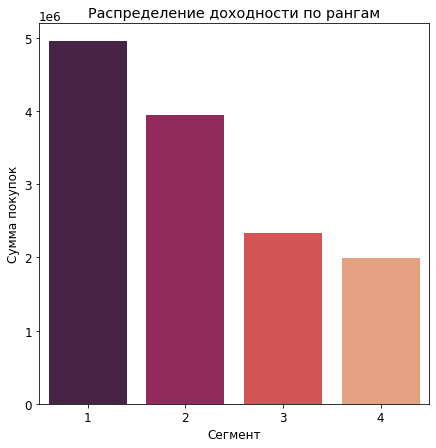

In [104]:
# Готовим датафрейм для барплота.
segments_monetary_df = rfm_df.groupby('m_rank', as_index=False) \
                            .agg({'monetary': 'sum'}) \
                            .rename(columns={'monetary': 'income_sum'})

# Строим график распределения доходности.
plt.figure(figsize=(7, 7))
sns.barplot(data=segments_monetary_df, x='m_rank', y='income_sum', palette='rocket')
plt.title('Распределение доходности по рангам')
plt.xlabel('Сегмент')
plt.ylabel('Сумма покупок')
plt.show()

Даже если бы мы к высоким по стоимости покупкам отнесли не только 4 ранг, но и 3, то этого все равно не хватило бы для того чтобы сравняться с самыми дешовыми покупками (1 рангом). Теперь мы точно знаем, что 1-2 ранг в monetary - составляет основную основную доходность.

## Выводы после 5-6 задания о нашей компании/сервисе.

В исследуемой нами компании/сервисе по сути стоит одна и самая серьезная проблема - удержание клиентов. Когортный анализ и rfm анализ показали, что компания по сути живет за счет потока новых клиентов, которые делают на небольшие покупки. После чего со временем попадают в 111 сегмент.

Компании необходимо разработать (или доработать) систему лоялности и скидок для пользователей. Только после решения проблемы с удержанием пользователей можно двигаться в развитии данной компании. При этом нельзя терять поток новых клиентов (они составляют доход компании в настоящий момент) и завлекать разными способами.

Стоит попытаться вернуть клиентов из более высокого ранга в monetary, при этом не забывать стимулировать их постоянно для совершения покупок (особые коммерческие предложения и условия).